# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')




AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

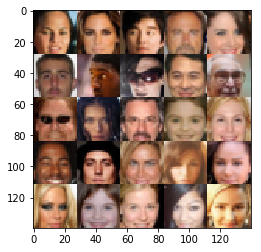

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28, 28, 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 2.1222... Generator Loss: 13.8077
Epoch 1/2... Discriminator Loss: 0.4540... Generator Loss: 2.5829
Epoch 1/2... Discriminator Loss: 1.7934... Generator Loss: 0.3014
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.4311
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 3.5539
Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 2.7291
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 1.7537
Epoch 1/2... Discriminator Loss: 2.7543... Generator Loss: 0.1623
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 2.9542
Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 1.6240


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.4937... Generator Loss: 2.4601
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.5012
Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 1.4041
Epoch 1/2... Discriminator Loss: 1.7039... Generator Loss: 0.3532
Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.3488
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 2.1505
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.6992
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.7702


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 3.7702
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 1.2487
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 1.4469
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 3.6520
Epoch 1/2... Discriminator Loss: 1.5666... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 1.7556
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.7776


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 2.1920
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 1.1087
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 2.3853
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 0.7040... Generator Loss: 1.4393
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 3.3103
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 3.2242
Epoch 1/2... Discriminator Loss: 1.9916... Generator Loss: 0.2639


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.8322... Generator Loss: 1.1458
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.3400
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 2.6149
Epoch 1/2... Discriminator Loss: 1.6431... Generator Loss: 0.3697
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 2.6375
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.2819
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.6300


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 2.6130
Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.7664
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.4065
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.4215
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.2217
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 0.9736
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.0327


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.9721... Generator Loss: 0.2633
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.5827
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 2.0942... Generator Loss: 0.2486
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.2078
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.5307
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 2.7785
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 1.1911


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 0.8964
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.8150
Epoch 1/2... Discriminator Loss: 0.8075... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 0.6356
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 2.6198... Generator Loss: 4.2765
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 0.8924
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 1.9756
Epoch 1/2... Discriminator Loss: 0.8336... Generator Loss: 1.5283


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 1.5325
Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 1.1726
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 2.0421
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.4129
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.7334
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.5315


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 2.0725
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 0.8829
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 0.6559
Epoch 2/2... Discriminator Loss: 1.7157... Generator Loss: 0.3462
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.6329
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 0.9664
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 2.1016


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9888... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 1.7748... Generator Loss: 0.3582
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 2.5202
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.5659
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 3.2482... Generator Loss: 5.7552
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 1.2433


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.4153
Epoch 2/2... Discriminator Loss: 1.5672... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.4113
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.9782... Generator Loss: 0.2813
Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 0.7141
Epoch 2/2... Discriminator Loss: 0.7806... Generator Loss: 1.1794


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.5585
Epoch 2/2... Discriminator Loss: 1.7182... Generator Loss: 0.3480
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.3836
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 2.9094
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.5679... Generator Loss: 0.4464
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 0.8185


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 0.8239... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 1.1369... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 0.7231... Generator Loss: 1.2971
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.7584
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 1.3711


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 2.1128... Generator Loss: 3.5887
Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 1.4838
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 1.2266
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 1.3971
Epoch 2/2... Discriminator Loss: 1.7613... Generator Loss: 0.3576
Epoch 2/2... Discriminator Loss: 2.1356... Generator Loss: 3.5761
Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 1.0506
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 0.9454


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.6173... Generator Loss: 1.5028
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 1.6895
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 2.5135... Generator Loss: 4.2506
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.3218
Epoch 2/2... Discriminator Loss: 1.7964... Generator Loss: 0.3375
Epoch 2/2... Discriminator Loss: 0.6621... Generator Loss: 1.5137
Epoch 2/2... Discriminator Loss: 2.7011... Generator Loss: 0.1559
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.6784


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 0.9912
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.5826
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 2.5061
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.1780


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.7300... Generator Loss: 1.2701
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 2.1870... Generator Loss: 0.2318
Epoch 2/2... Discriminator Loss: 0.6540... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.4154
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 1.6537... Generator Loss: 3.9768


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.7952... Generator Loss: 0.3215
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 1.2454
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 2.1978
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 1.2754
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.9260


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.8663
Epoch 1/1... Discriminator Loss: 2.5442... Generator Loss: 0.1628
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 9.7755
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 4.1086
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 3.1647
Epoch 1/1... Discriminator Loss: 2.0149... Generator Loss: 6.5499
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 6.4894
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 3.8039


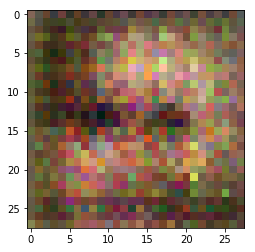

Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 2.7881
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 2.3028
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 3.1874
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 2.6122
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6046


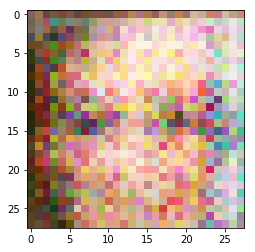

Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 2.7734
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 4.4599
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 3.2838
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.4568
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 2.0213
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 4.4626


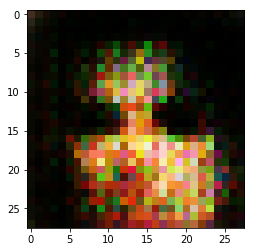

Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.5620
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 3.3880
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 2.8585
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 3.6241
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 2.3596
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 2.3704


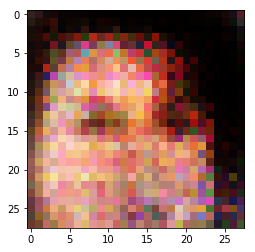

Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 2.1009
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 1.7823
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 3.7666
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 2.6554


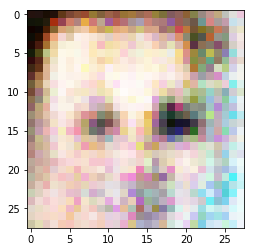

Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.8257
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 2.6172
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.8036
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.1160
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.7723


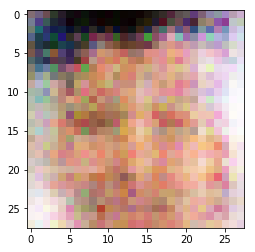

Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 2.1528
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 2.3505
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 2.1113
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 1.9451
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.8337
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.5761


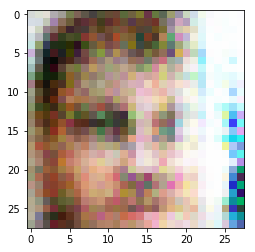

Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 2.7557
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 2.7600
Epoch 1/1... Discriminator Loss: 1.6522... Generator Loss: 4.8585
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.3923
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 3.9572
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.5550
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.0581


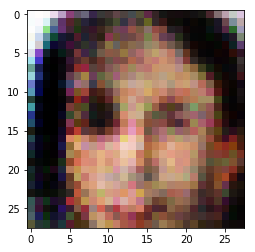

Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 2.3945
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 4.0729
Epoch 1/1... Discriminator Loss: 1.6658... Generator Loss: 4.7053
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.4983
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.8458
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 2.9073
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.4093
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 3.2359
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 2.9487


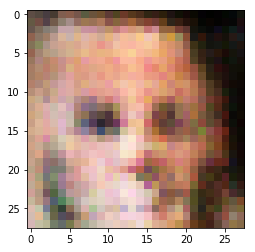

Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.3649
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 3.4356
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.4729
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.3904
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 2.3355
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 3.8014
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 2.5858


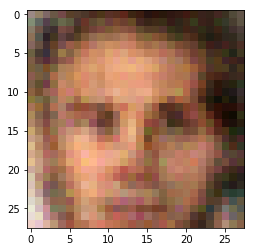

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.